<a href="https://colab.research.google.com/github/LACDR-CDS/SCDR_RNAseq/blob/main/Session2_group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 2

In this session, you will go through the basic processing steps of RNA sequencing data. Using the steps taught in the lecture and repeated below, as well as the **cheat sheet** provided on Brightspace/Teams, you will write your own code to process and analyze the data.

Each team receives a count matrix with 4 samples: **2 ESC replicates** and 2 replicates which belong to one of the following stages of cardiomyocyte differentiation:

*   mesoderm
*   cardiomyocyte progenitors
*   cardiomyocytes
*   fetal heart

Your goal is to **label the samples with the correct stage** (both ESCs and differentiated).



## Setup

Run the following cells to set up the necessary packages and download the data. If you wish to use a package which is not in the list below, you will need to install and import it yourself.

In [2]:
#Install packages which are not in the default environment
%pip install scanpy
%pip install pydeseq2
%pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 kB 10.2 MB/s eta 0:00:00


In [3]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pickle
import gseapy


In [4]:
group_number = 3

In [5]:
#Make data directory if it does not exist
os.makedirs("data", exist_ok=True)
os.makedirs("plots", exist_ok=True)

#Download datasets in the data folder
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session2/data/group{group_number}.txt -O data/group{group_number}.txt
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session2/data/metadata.csv -O data/group{group_number}_metadata.csv

--2025-11-03 19:05:31--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session2/data/group3.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889632 (869K) [text/plain]
Saving to: ‘data/group3.txt’

data/group3.txt     100%[===================>] 868.78K  --.-KB/s    in 0.05s   

2025-11-03 19:05:32 (18.4 MB/s) - ‘data/group3.txt’ saved [889632/889632]

--2025-11-03 19:05:32--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session2/data/metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.


## Data import

In the empty cell(s) below, please do the following and answer the given questions:

1) Read the count matrix (the path should be: `"data/groupN.txt`", where N is your group number).
2) Check the orientation of the count table (`genes x samples` or `samples x genes`).
3) How many samples and genes there are in the count table?
4) Read the corresponding metadata table ( `"data/groupN_metadata.csv`"). What cell line do the samples belong to?

In [6]:
# Question 1: Read count table
count_table = pd.read_csv(f"data/group{group_number}.txt", sep="\t", index_col = 0)
print ('1.', count_table.head())
# Question 2
print ('2. The count table is oriented as genes x samples')
# Question 3
print ('3. There are', count_table.shape[0], 'genes and', count_table.shape[1], 'samples.')
#Question 4
metadata = pd.read_csv(f"data/group{group_number}_metadata.csv", index_col = 0)
print (metadata.head())
print ("4. The samples are from the RUES2 cell line.")

1.              sample1  sample2  sample3  sample4
DDX11L1            0        0        0        0
WASH7P           111      148      203       79
MIR6859-1          5        2        3        2
MIR1302-2HG        4        0        2        2
MIR1302-2          0        0        0        0
2. The count table is oriented as genes x samples
3. There are 42844 genes and 4 samples.
             stage cell line
sample_id                   
sample1    Unknown     RUES2
sample2    Unknown     RUES2
sample3    Unknown     RUES2
sample4    Unknown     RUES2
4. The samples are from the RUES2 cell line.


## Filtering

Now that you have become familiar with the structure of your **raw data**, you can start the processing steps. First, the data must be filtered such that we remove **genes with less than 10 reads over all samples**. We do this to remove possible noise/experimental artefacts, which decrease statistical confidence. Reference the cheat sheet for help with coding. Perform the filtering and answer the following questions:

1) Which genes have low overall read counts (lowest total gene count number that is higher than 0)?

*Hint: use gene_count_sums.sort_values() to sort the results*

2) How many genes are left in the count table after filtering?
3) How many reads does each sample have for OCT4?


In [7]:
# Filtering
gene_count_sums = count_table.sum(axis=1) #Number of counts per gene
print ('Number of counts per gene:\n', gene_count_sums.head())

filtered_count_table= count_table[gene_count_sums >= 10] #Filter
print ('Filtered count table:\n', filtered_count_table.head())

# Question 1
print ('\n 1. Genes with lowest 10 counts:\n',gene_count_sums [gene_count_sums >0].sort_values()[:10])

# Question 2
print ('2. After filtering, there are', filtered_count_table.shape[0], 'genes.')

#Question
print ('3.', filtered_count_table.loc['POU5F1'])

Number of counts per gene:
 DDX11L1          0
WASH7P         541
MIR6859-1       12
MIR1302-2HG      8
MIR1302-2        0
dtype: int64
Filtered count table:
               sample1  sample2  sample3  sample4
WASH7P            111      148      203       79
MIR6859-1           5        2        3        2
LOC124900384       12        1        3       19
LOC729737          43       23       26      119
DDX11L17            2        1        2       11

 1. Genes with lowest 10 counts:
 LOC124903815    1
MIR6859-2       1
LOC124903816    1
NTRK3-AS1       1
MIR11181        1
LOC124903579    1
LOC102724452    1
LOC124906290    1
MIR1234         1
LOC105374124    1
dtype: int64
2. After filtering, there are 24723 genes.
3. sample1    46396
sample2       19
sample3       25
sample4    43717
Name: POU5F1, dtype: int64


## Normalization: counts per million

In order to account for differences in sequencing depth among samples (a sample that has been sequenced deeper will also have more gene counts overall, but this does not necessarily reflect the biology), we **normalize the gene counts** to the **total number of reads in a sample** and multiply by **1 million**. Use the cheat sheet to help you write the code. Normalize your count table and answer the following questions:

1. Which sample is the most deeply sequenced and which one is the most shallow? Can you see this from the normalized table?
2. Which gene has the highest average expression value after normalization?
*Hint: take the average of each row and sort it in descending order using df.sort_values(ascending = False) to keep the gene names visible.*

In [8]:
# Normalize reads
total_reads = filtered_count_table.sum(axis = 0)
normalized_count_table = (filtered_count_table /total_reads) * 1000000
log_transformed_counts = np.log2(normalized_count_table + 1)
print ('Normalized read counts:\n', log_transformed_counts.head())

# Question 1
print ("1. This cannot be seen from the normalized table, as we don't have the raw gene counts anymore. To check, we look at the total read number per sample.")
print (total_reads, '\n max:', max(total_reads), '\n min:', min(total_reads))

# Question 2
print ('2.', log_transformed_counts.mean(axis = 1).sort_values(ascending = False).head())

Normalized read counts:
                sample1   sample2   sample3   sample4
WASH7P        1.923324  2.248633  2.258258  1.585759
MIR6859-1     0.170962  0.071360  0.078505  0.071316
LOC124900384  0.380665  0.036121  0.078505  0.566972
LOC729737     1.057941  0.662781  0.570140  2.005455
DDX11L17      0.070834  0.036121  0.052808  0.354691
1. This cannot be seen from the normalized table, as we don't have the raw gene counts anymore. To check, we look at the total read number per sample.
sample1    39742771
sample2    39442242
sample3    53645038
sample4    39467326
dtype: int64 
 max: 53645038 
 min: 39442242
2. RNR2      17.546783
RNR1      14.775056
RN7SL1    13.618850
RN7SK     12.979322
EEF1A1    12.213406
dtype: float64


## Principal Component Analysis

Principal Component Analysis (PCA) is a dimension reduction method. In order to visualise the distribution of our samples in a 2D plot, we need to reduce the count matrix from its high number of dimensions (in this case, the read count value for each gene represents a dimension) to less, out of which we then plot the first two.

1) PCA requires the data to be transposed and scaled to mean 0 and unit variance. Use the cheat sheet to find the correct function and standardize the data.
2) Run the PCA function. What is the shape of the resulting matrix? What do the rows and columns represent? (which are the samples and which are the principal components?)
3) Plot the first two principal components. How many samples have you plotted?
4) Which samples group together? Are there any outliers?

2. The shape of the PCA matrix is (4, 4) . The rows are the samples, and the columns are the principal components.
[[-1.32916875e+02  5.74384100e+01 -6.08066632e+01  3.38730778e-13]
 [ 1.25803258e+02  6.40733991e+01  5.75947138e+01  3.38730778e-13]
 [ 1.40029950e+02 -6.07336074e+01 -5.45928436e+01  3.38730778e-13]
 [-1.32916333e+02 -6.07782016e+01  5.78047930e+01  3.38730778e-13]]


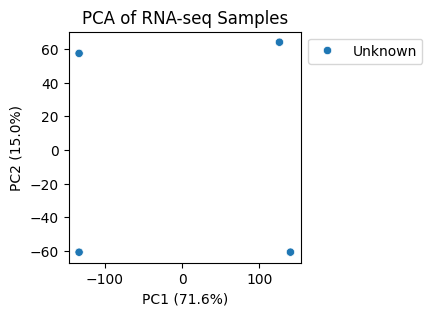

In [9]:
# Question 1
# Scale
scaler = StandardScaler()
scaled_table = scaler.fit_transform(log_transformed_counts.T)

# Question 2
# PCA
pca = PCA()
pca_result_matrix= pca.fit_transform(scaled_table)
print ("2. The shape of the PCA matrix is", np.shape(pca_result_matrix), '. The rows are the samples, and the columns are the principal components.')
print (pca_result_matrix)

# Question 3 : PCA PLOT
plot_df = pd.DataFrame({
 "PC1": pca_result_matrix[:, 0],
 "PC2": pca_result_matrix[:, 1],
 "condition": metadata["stage"].values
})
plt.figure(figsize=(3, 3))
sns.scatterplot(
data=plot_df,
x="PC1", y="PC2",
hue="condition"
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of RNA-seq Samples")
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("plots/PCA_session2.png", dpi = 200)
plt.show()





### Gene markers

Now it is time to label your data. Use the cheat sheet to create a heatmap plot showing known marker genes for each possible differentiation stage:
1. Embryonic Stem Cells
2. Mesoderm
3. Cardiomyocyte progenitors
4. Cardiomyocytes
5. Mature fetal heart

Label the stem cell replicates. Then, identify which stage the other two samples belong to according to the gene expression values in your heatmap. Feel free to consult among yourselves and compare heatmaps if you find it difficult to choose between potential stages.

Add your chosen labels to the metadata table (replace the 'Unknown' in column 'stage' with your chosen label) and verify the clustering in a labelled PCA plot.

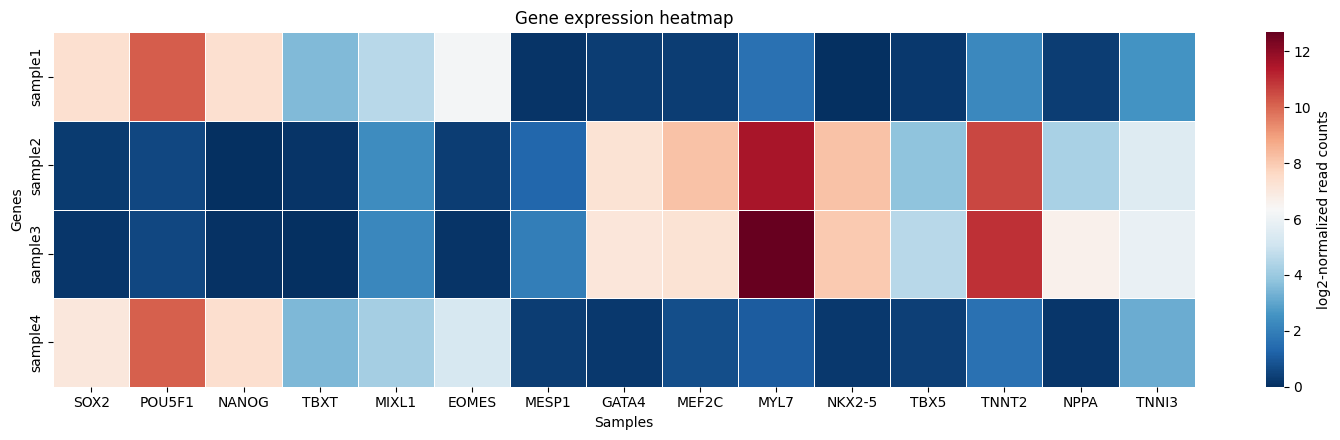

In [10]:
stages = {
    "Pluripotent": ["OCT4", "SOX2", "NANOG"],
    "Mesoderm": ["MIXL1", "EOMES", "TBXT", "MESP1"],
    "Cardiac committed mesoderm": ["PDGFRA", "FLK1", "PDGFRB", "ISL1"],
    "Cardiac progenitors": ["HAND2", "GATA4", "HAND1", "MEF2C"],
    "Early cardiomyocytes": ["MYL7", "ACTC1", "TNNT2", "MYH6", "SLC8A1", "NKX2-5", "TBX5"],
    "Late cardiomyocytes": ["MYH7", "MYL2", "VCAM1", "SIRPA", "IRX4", "RYR2", "CACNA1C",  "SCN5A"],
    'Heart':['MYL7', 'TNNT2', 'NPPA', 'TNNI3']
}

gene_list = ["SOX2", "POU5F1", "NANOG", "TBXT", "MIXL1", "EOMES", "MESP1","GATA4","MEF2C", "MYL7", "NKX2-5", "TBX5", "TNNT2", 'NPPA', 'TNNI3']
subset = log_transformed_counts.loc[log_transformed_counts.index.intersection(gene_list)].T
subset = subset[gene_list]
plt.figure(figsize=( len(gene_list), 4.5))
sns.heatmap(
    subset,
    cmap="RdBu_r",
    linecolor = "white",
    linewidth = 0.5,
    cbar_kws={"label": "log2-normalized read counts"}
)
plt.title("Gene expression heatmap")
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.tight_layout()
plt.savefig("plots/heatmap_session2.png", dpi = 200)
plt.show()


In [ ]:
#Label samples
metadata.loc['sample1']['stage'] = 'ESC'
metadata.loc['sample2']['stage'] = 'cardiomyocyte'
metadata.loc['sample3']['stage'] = 'cardiomyocyte'
metadata.loc['sample4']['stage'] = 'ESC'
metadata

,stage,cell line
sample_id,,
sample1,ESC,RUES2
sample2,cardiomyocyte,RUES2
sample3,cardiomyocyte,RUES2
sample4,ESC,RUES2


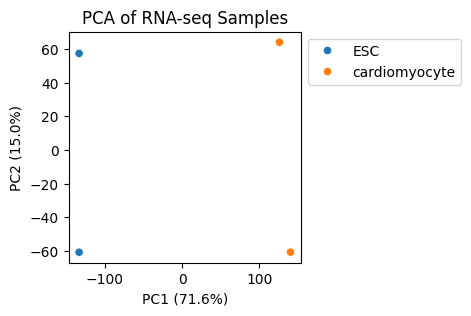

In [ ]:
# Question 3 : PCA PLOT
plot_df = pd.DataFrame({
 "PC1": pca_result_matrix[:, 0],
 "PC2": pca_result_matrix[:, 1],
 "condition": metadata["stage"].values
})
plt.figure(figsize=(3, 3))
sns.scatterplot(
data=plot_df,
x="PC1", y="PC2",
hue="condition"
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of RNA-seq Samples")
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("plots/PCA_session2_labeled.png", dpi = 200)
plt.show()
